In [3]:
### Si données locales
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA
mae.rmse <- function(m, m.hat) {
    return(list(mae=mean(abs(m - m.hat), na.rm=T), rmse=sqrt(mean((m - m.hat)^2, na.rm=T))))
}
new.m.mae.rmse <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae.rmse(m.svd2, m)
    }

In [9]:
library(bcv)

In [4]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2[i.test.b]*5, m.na[i.test.b])
    }
to.plot <- c()

In [17]:
i.observed <- which(m > 0)
i.hasard <- sample(i.observed, length(i.observed))
length(i.hasard)
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
for (i in seq_len(5)){
fold.number <- i

## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false
## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
m.train.na <- m.train
m.train.na[m.train==0]<-NA
m.mean <- outer(rowMeans(m.train.na,na.rm=T),colMeans(m.train.na,na.rm=T),FUN="+")/2
m.mean[!is.finite(m.mean)]<- rowMeans(m.mean,na.rm=T)
m.train[m.train==0] <-m.mean[m.train==0]
m.train <- m.train/5
m.svd <- svd(m.train)
to.plot<-rbind(to.plot,unlist(lapply(seq(22), new.m.cv)))
    }


[1] 100000

In [19]:
to.plot<-apply(to.plot,2,unlist)

In [20]:
sdev <- apply(to.plot,2,sd) 
sdev
avg <- colMeans(to.plot)
x <- 1:length(avg)

[1] 0.003034999 0.003417447 0.003366079 0.003474065 0.003903607 0.003846170
 [7] 0.003681838 0.003658180 0.003314755 0.003542298 0.003416933 0.003258253
[13] 0.002644469 0.003022368 0.003146167 0.003211935 0.003395240 0.003411591
[19] 0.003242860 0.003162535 0.003239979 0.003396864

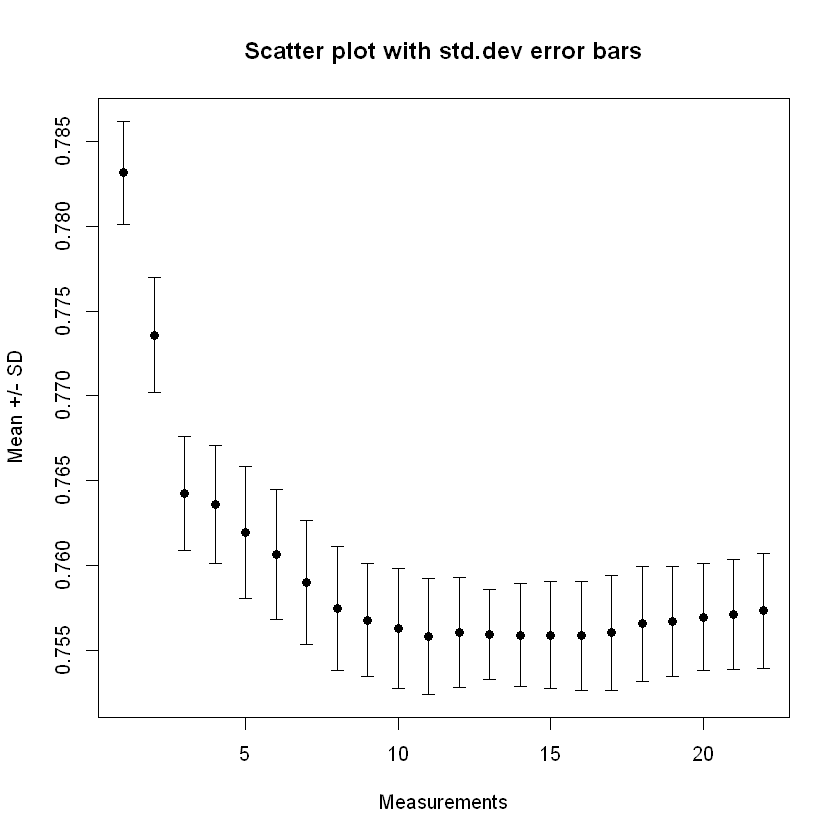

In [21]:
plot(x,colMeans(to.plot),ylim=range(c(avg-sdev, avg+sdev)),pch=19, xlab="Measurements", ylab="Mean +/- SD",
    main="Scatter plot with std.dev error bars"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)